<a href="https://colab.research.google.com/github/BenaJovi/CSCI_166_Project/blob/main/CSCI166_MsPacman_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎮 Deep Q-Learning on MsPacman (CSCI 166 Project)

This Colab notebook runs a **complete DQN study** on the Atari game **MsPacman** with three configurations:

1. **Baseline DQN**  
2. **Double DQN** (stability via target selection)  
3. **Dueling DQN** (model-side improvement with value + advantage streams)  

All three use:

- Experience replay  
- Target network syncing  
- Epsilon-greedy exploration with decay  
- Standard Atari preprocessing (frame stacking, grayscale, resizing, etc.)  

The notebook also:

- Plots **learning curves** for all three variants on the same axes  
- Records short gameplay


## 1. Install Dependencies

Run this once per fresh Colab runtime to install Atari / Gymnasium / AutoROM packages.


In [20]:
# 🧹 Clean up any older AutoROM variants to avoid conflicts
!pip uninstall -y AutoROM AutoROM.accept-rom-license autorom >/dev/null 2>&1

# 🧱 Install AutoROM CLI, Gymnasium Atari extras, and Stable-Baselines3 (for Atari wrappers)
!pip install gymnasium[atari,accept-rom-license]
!pip install autorom
!pip install stable-baselines3


  Using cached AutoROM-0.6.1-py3-none-any.whl.metadata (2.4 kB)
Using cached AutoROM-0.6.1-py3-none-any.whl (9.4 kB)


## 2. Install Atari ROMs

This uses `AutoROM.accept-rom-license` to download and install Atari ROMs (including MsPacman).  
You must have internet access enabled in Colab when running this.


In [21]:
import ale_py
import gymnasium as gym

## 3. Imports

Core libraries: Gymnasium for environments, PyTorch for neural networks, and utilities for logging and replay.


In [22]:
import gymnasium as gym
import numpy as np
import collections
import typing as tt
from dataclasses import dataclass
from datetime import datetime
import time
import os
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard.writer import SummaryWriter

from gymnasium import spaces
from stable_baselines3.common import atari_wrappers


## 4.Mount Google Drive for Saving Models



In [23]:
from google.colab import drive
drive.mount('/content/drive')

# Directories where models will be saved
save_dir_drive = "/content/drive/MyDrive/PUBLIC/Models"
save_dir_local = "saved_models"

os.makedirs(save_dir_drive, exist_ok=True)
os.makedirs(save_dir_local, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 5. Global Configuration (MsPacman + Hyperparameters)

We define:

- Environment name (MsPacman)  
- DQN hyperparameters  
- Epsilon-greedy schedule  
- A global switch `USE_DOUBLE_DQN` to toggle **DQN vs Double DQN** logic.


In [24]:
# Environment (MsPacman)
DEFAULT_ENV_NAME = "ALE/MsPacman-v5"
env_name = DEFAULT_ENV_NAME

# Base training hyperparameters
GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 100_000
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 1_000
REPLAY_START_SIZE = 10_000

# Epsilon-greedy schedule
EPSILON_START = 1.0
EPSILON_FINAL = 0.01
EPSILON_DECAY_LAST_FRAME = 200_000

# Project-specific stopping rule (you can adjust this up)
MEAN_REWARD_BOUND_DEFAULT = 100.0  # average reward over last 100 episodes

# Global toggle for loss function: baseline DQN vs Double DQN
USE_DOUBLE_DQN = False   # Will be set inside the training function for each run

# Logging helper
safe_env_name = env_name.replace("/", "_")

# Type aliases
State = np.ndarray
Action = int
BatchTensors = tt.Tuple[
    torch.ByteTensor,   # states
    torch.LongTensor,   # actions
    torch.Tensor,       # rewards
    torch.BoolTensor,   # done | trunc
    torch.ByteTensor    # next states
]


## 6. Q-Network Architectures

We implement two architectures:

1. **Standard DQN** – a CNN followed by fully-connected layers → Q(s, a)  
2. **Dueling DQN** – shared CNN trunk, then separate **value** and **advantage** streams:
   - V(s): scalar
   - A(s, a): per-action advantage
   - Q(s, a) = V(s) + (A(s, a) − mean_a A(s, a))


In [25]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            conv_out_size = self.conv(dummy).size(-1)

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions),
        )

    def forward(self, x: torch.ByteTensor):
        # Observations are uint8 frames in [0, 255]
        x = x.float() / 255.0
        x = self.conv(x)
        q = self.fc(x)
        return q


class DuelingDQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            conv_out_size = self.conv(dummy).size(-1)

        # Value stream
        self.value_stream = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

        # Advantage stream
        self.advantage_stream = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions),
        )

    def forward(self, x: torch.ByteTensor):
        x = x.float() / 255.0
        x = self.conv(x)

        value = self.value_stream(x)                # (B, 1)
        advantage = self.advantage_stream(x)        # (B, n_actions)

        # Q(s,a) = V(s) + (A(s,a) - mean_a A(s,a))
        advantage_mean = advantage.mean(dim=1, keepdim=True)
        q_vals = value + (advantage - advantage_mean)
        return q_vals


## 7. Atari Preprocessing Wrappers

We apply standard preprocessing:

- `AtariWrapper` (frame skipping, grayscale, resizing, etc.)  
- Channel reordering (H, W, C) → (C, H, W)  
- Frame stacking (e.g., 4 frames)  
- Optional "FIRE" action on reset (harmless for MsPacman)


In [26]:
class ImageToPyTorch(gym.ObservationWrapper):
    # Convert observations from (H, W, C) to (C, H, W) for PyTorch.
    def __init__(self, env):
        super().__init__(env)
        obs = self.observation_space
        assert isinstance(obs, spaces.Box)
        assert len(obs.shape) == 3  # H, W, C
        h, w, c = obs.shape
        self.observation_space = spaces.Box(
            low=obs.low.min(),
            high=obs.high.max(),
            shape=(c, h, w),
            dtype=obs.dtype,
        )

    def observation(self, observation: np.ndarray) -> np.ndarray:
        # (H, W, C) → (C, H, W)
        return np.moveaxis(observation, 2, 0)


class BufferWrapper(gym.ObservationWrapper):
    # Stack last n_steps frames along the channel dimension.
    def __init__(self, env, n_steps: int):
        super().__init__(env)
        obs = env.observation_space
        assert isinstance(obs, spaces.Box)
        self.buffer = collections.deque(maxlen=n_steps)

        low = np.repeat(obs.low, n_steps, axis=0)
        high = np.repeat(obs.high, n_steps, axis=0)

        self.observation_space = spaces.Box(
            low=low,
            high=high,
            dtype=obs.dtype,
        )

    def reset(self, *, seed: tt.Optional[int] = None, options: tt.Optional[dict] = None):
        obs, info = self.env.reset(seed=seed, options=options)
        self.buffer.clear()
        for _ in range(self.buffer.maxlen):
            self.buffer.append(np.zeros_like(obs))
        return self.observation(obs), info

    def observation(self, observation: np.ndarray) -> np.ndarray:
        self.buffer.append(observation)
        return np.concatenate(list(self.buffer), axis=0)


class FireResetEnv:
    # After reset, take a FIRE action if needed (for some Atari games).
    # This is commonly used on e.g. Breakout; it is harmless for MsPacman.
    def __init__(self, env):
        self.env = env
        self.action_space = env.action_space
        self.observation_space = env.observation_space

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        try:
            obs, _, term, trunc, info = self.env.step(1)
            if term or trunc:
                obs, info = self.env.reset(**kwargs)
        except Exception:
            # Some games do not require a FIRE action
            pass
        return obs, info

    def step(self, action):
        return self.env.step(action)

    def __getattr__(self, name):
        return getattr(self.env, name)


def make_env(env_name: str, n_steps: int = 4, render_mode=None, **kwargs):
    print(f"Creating environment {env_name}")
    env = gym.make(env_name, render_mode=render_mode, **kwargs)
    # Stable-Baselines3 Atari preprocessing: resize, gray, frame-skip, etc.
    env = atari_wrappers.AtariWrapper(env, clip_reward=False, noop_max=30)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, n_steps=n_steps)
    env = FireResetEnv(env)
    return env


## 8. Experience Replay Buffer

We store transitions `(state, action, reward, done, next_state)` in a fixed-size buffer and sample random minibatches for training.


In [27]:
@dataclass
class Experience:
    state: State
    action: Action
    reward: float
    done_trunc: bool
    new_state: State


class ExperienceBuffer:
    def __init__(self, capacity: int):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience: Experience):
        self.buffer.append(experience)

    def sample(self, batch_size: int) -> tt.List[Experience]:
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        return [self.buffer[idx] for idx in indices]


## 9. Epsilon-Greedy Agent

The agent:

- Keeps track of the current state and running episode reward  
- Uses **epsilon-greedy** exploration  
- Adds transitions into the replay buffer


In [28]:
class Agent:
    def __init__(self, env: gym.Env, exp_buffer: ExperienceBuffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self.state: tt.Optional[np.ndarray] = None
        self.total_reward = 0.0
        self._reset()

    def _reset(self):
        self.state, _ = self.env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(
        self,
        net: nn.Module,
        device: torch.device,
        epsilon: float = 0.0
    ) -> tt.Optional[float]:
        done_reward = None

        # Epsilon-greedy action selection
        if np.random.random() < epsilon:
            action = self.env.action_space.sample()
        else:
            state_v = torch.as_tensor(self.state, device=device).unsqueeze(0)
            q_vals = net(state_v)
            _, act_v = torch.max(q_vals, dim=1)
            action = int(act_v.item())

        new_state, reward, is_done, is_trunc, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(
            state=self.state,
            action=action,
            reward=float(reward),
            done_trunc=bool(is_done or is_trunc),
            new_state=new_state,
        )
        self.exp_buffer.append(exp)
        self.state = new_state

        if is_done or is_trunc:
            done_reward = self.total_reward
            self._reset()

        return done_reward


## 10. Batch Helper and Loss Function (DQN vs Double DQN)

We convert a list of `Experience` objects into tensors, and compute the **DQN / Double DQN** loss:

- **DQN:** uses `max_a' Q_target(s', a')`  
- **Double DQN:** uses online net to pick the best action, target net to evaluate it  

The **network architecture** (standard vs dueling) is separate from the **loss logic**.  
That's why Double vs non-Double is controlled by `USE_DOUBLE_DQN`, and Dueling is controlled by which class we instantiate (`DQN` vs `DuelingDQN`).


In [29]:
def batch_to_tensors(batch: tt.List[Experience], device: torch.device) -> BatchTensors:
    states, actions, rewards, dones, new_states = [], [], [], [], []

    for e in batch:
        states.append(e.state)
        actions.append(e.action)
        rewards.append(e.reward)
        dones.append(e.done_trunc)
        new_states.append(e.new_state)

    states_t = torch.as_tensor(np.asarray(states))
    actions_t = torch.as_tensor(actions, dtype=torch.long)
    rewards_t = torch.as_tensor(rewards, dtype=torch.float32)
    dones_t = torch.as_tensor(dones, dtype=torch.bool)
    new_states_t = torch.as_tensor(np.asarray(new_states))

    return (
        states_t.to(device),
        actions_t.to(device),
        rewards_t.to(device),
        dones_t.to(device),
        new_states_t.to(device),
    )


def calc_loss(
    batch: tt.List[Experience],
    net: nn.Module,
    tgt_net: nn.Module,
    device: torch.device,
) -> torch.Tensor:
    states_t, actions_t, rewards_t, dones_t, new_states_t = batch_to_tensors(batch, device)

    # Q(s, a) for the actions actually taken
    q_values = net(states_t)
    state_action_values = q_values.gather(1, actions_t.unsqueeze(-1)).squeeze(-1)

    with torch.no_grad():
        if USE_DOUBLE_DQN:
            # Double DQN: online net selects argmax action, target net evaluates it
            next_q_online = net(new_states_t)
            next_actions = next_q_online.argmax(dim=1)

            next_q_target = tgt_net(new_states_t)
            next_state_values = next_q_target.gather(
                1, next_actions.unsqueeze(-1)
            ).squeeze(-1)
        else:
            # Vanilla DQN
            next_q_target = tgt_net(new_states_t)
            next_state_values = next_q_target.max(1)[0]

        next_state_values[dones_t] = 0.0

    expected_state_action_values = rewards_t + GAMMA * next_state_values
    return nn.MSELoss()(state_action_values, expected_state_action_values)


## 11. Training Function (Baseline / Double / Dueling)

The function below runs a **complete DQN training loop** on MsPacman.

Arguments:

- `double_dqn`: whether to use Double DQN target selection  
- `use_dueling`: whether to use the Dueling architecture (value + advantage streams)  

This gives you three main configurations for the project:

1. `double_dqn=False, use_dueling=False` → **Baseline DQN**  
2. `double_dqn=True,  use_dueling=False` → **Double DQN**  
3. `double_dqn=True,  use_dueling=True`  → **Dueling Double DQN** (common in practice)


In [30]:
def build_q_net(input_shape, n_actions, use_dueling: bool) -> nn.Module:
    if use_dueling:
        return DuelingDQN(input_shape, n_actions)
    else:
        return DQN(input_shape, n_actions)


def train_dqn(
    double_dqn: bool,
    use_dueling: bool,
    run_name: str,
    train_max_frames: int = 150_000,
    mean_reward_bound: float = MEAN_REWARD_BOUND_DEFAULT,
):
    global USE_DOUBLE_DQN
    USE_DOUBLE_DQN = double_dqn

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if use_dueling and double_dqn:
        variant_name = "DuelingDoubleDQN"
    elif use_dueling and not double_dqn:
        variant_name = "DuelingDQN_NoDouble"
    elif double_dqn:
        variant_name = "DoubleDQN"
    else:
        variant_name = "DQN"

    print(f"Using device: {device} | Variant: {variant_name}")

    env = make_env(env_name)
    obs_shape = env.observation_space.shape
    n_actions = env.action_space.n

    net = build_q_net(obs_shape, n_actions, use_dueling=use_dueling).to(device)
    tgt_net = build_q_net(obs_shape, n_actions, use_dueling=use_dueling).to(device)
    tgt_net.load_state_dict(net.state_dict())

    buffer = ExperienceBuffer(REPLAY_SIZE)
    agent = Agent(env, buffer)
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

    # Model comment like the professor's snippet
    model_comment = f"epsdec{EPSILON_DECAY_LAST_FRAME}_rs{REPLAY_START_SIZE}_sync{SYNC_TARGET_FRAMES}_{variant_name}"
    writer = SummaryWriter(comment=f"-{safe_env_name}-{model_comment}")

    total_rewards = []
    best_mean_reward = None
    epsilon = EPSILON_START
    frame_idx = 0
    ts_frame = 0
    ts = time.time()
    start_time = time.time()

    # Histories for plotting
    frame_history = []
    reward_history = []
    mean100_history = []

    # Keep runs short enough to allow clips
    TRAIN_MAX_FRAMES = train_max_frames

    while True:
        frame_idx += 1

        # Epsilon schedule
        epsilon = max(
            EPSILON_FINAL,
            EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME
        )

        reward = agent.play_step(net, device=device, epsilon=epsilon)

        if reward is not None:
            total_rewards.append(reward)

            speed = (frame_idx - ts_frame) / (time.time() - ts + 1e-8)
            elapsed = time.time() - start_time
            ts_frame = frame_idx
            ts = time.time()

            mean_reward = float(np.mean(total_rewards[-100:])) if total_rewards else 0.0

            writer.add_scalar("epsilon", epsilon, frame_idx)
            writer.add_scalar("speed", speed, frame_idx)
            writer.add_scalar("reward_100", mean_reward, frame_idx)
            writer.add_scalar("reward", reward, frame_idx)

            # Record histories
            frame_history.append(frame_idx)
            reward_history.append(reward)
            mean100_history.append(mean_reward)

            # Save best model
            SAVE_EPSILON = 1e-3  # small margin to avoid re-saving identical scores
            if best_mean_reward is None or mean_reward > best_mean_reward + SAVE_EPSILON:
                print(
                    f"[{variant_name}] {frame_idx}: done {len(total_rewards)} games, "
                    f"reward_100 {mean_reward:.3f}, eps {epsilon:.2f}, "
                    f"speed {speed:.2f} f/s, time {elapsed/60:.1f} min"
                )
                timestamp = datetime.now().strftime("%Y%m%d-%H%M")
                model_filename = f"{safe_env_name}-best_{int(mean_reward)}-{timestamp}-{model_comment}.dat"

                # Save to both paths
                model_path_drive = os.path.join(save_dir_drive, model_filename)
                model_path_local = os.path.join(save_dir_local, model_filename)
                torch.save(net.state_dict(), model_path_drive)
                torch.save(net.state_dict(), model_path_local)

                print(f"Model saved to: \n - Google Drive:\n - Google Drive: {model_path_drive}\n - Local:{model_path_local}")
                if best_mean_reward is not None:
                    print(f"Best reward updated {best_mean_reward:.3f} -> {mean_reward:.3f}")
                best_mean_reward = mean_reward

            # Project-style stopping rule
            if mean_reward >= mean_reward_bound and len(total_rewards) >= 50:
                print(f" {variant_name} reached mean_100={mean_reward:.1f} ≥ {mean_reward_bound}")
                break

        # Wait for buffer to fill before starting gradient updates
        if len(buffer) < REPLAY_START_SIZE:
            if frame_idx >= TRAIN_MAX_FRAMES:
                print(f"[{variant_name}] Stopping at TRAIN_MAX_FRAMES={TRAIN_MAX_FRAMES} (buffer filling).")
                break
            continue

        # Sync target network
        if frame_idx % SYNC_TARGET_FRAMES == 0:
            tgt_net.load_state_dict(net.state_dict())

        # Gradient step
        optimizer.zero_grad()
        batch = buffer.sample(BATCH_SIZE)
        loss_t = calc_loss(batch, net, tgt_net, device)
        loss_t.backward()
        optimizer.step()

        if frame_idx >= TRAIN_MAX_FRAMES:
            print(f"[{variant_name}] Reached TRAIN_MAX_FRAMES={TRAIN_MAX_FRAMES}.")
            break

    env.close()
    writer.close()

    stats = {
        "variant": variant_name,
        "frames": frame_idx,
        "episodes": len(total_rewards),
        "best_mean_reward": float(best_mean_reward) if best_mean_reward is not None else None,
    }

    histories = {
        "frames": frame_history,
        "reward": reward_history,
        "mean100": mean100_history,
    }

    # Return stats, histories, and the trained network (for videos)
    return stats, histories, net


## 12. Run All Three Variants on MsPacman

We now train:

1. **Baseline DQN:** `double_dqn=False, use_dueling=False`  
2. **Double DQN:**   `double_dqn=True,  use_dueling=False`  
3. **Dueling DQN:**  `double_dqn=True,  use_dueling=True`  (Dueling + Double)


In [38]:
# Baseline DQN
baseline_stats, baseline_hist, baseline_net = train_dqn(
    double_dqn=False,
    use_dueling=False,
    run_name="baseline_dqn",
    train_max_frames=500_000,
    mean_reward_bound=MEAN_REWARD_BOUND_DEFAULT,
)
print("Baseline DQN stats:", baseline_stats)

# Double DQN
double_stats, double_hist, double_net = train_dqn(
    double_dqn=True,
    use_dueling=False,
    run_name="double_dqn",
    train_max_frames=500_000,
    mean_reward_bound=MEAN_REWARD_BOUND_DEFAULT,
)
print("Double DQN stats:", double_stats)

# Dueling + Double DQN
dueling_stats, dueling_hist, dueling_net = train_dqn(
    double_dqn=True,
    use_dueling=True,
    run_name="dueling_dqn",
    train_max_frames=500_000,
    mean_reward_bound=MEAN_REWARD_BOUND_DEFAULT,
)
print("Dueling Double DQN stats:", dueling_stats)


Using device: cpu | Variant: DQN
Creating environment ALE/MsPacman-v5
[DQN] 42: done 1 games, reward_100 180.000, eps 1.00, speed 274.36 f/s, time 0.0 min
Model saved to: 
 - Google Drive:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_MsPacman-v5-best_180-20251126-0022-epsdec200000_rs10000_sync1000_DQN.dat
 - Local:saved_models/ALE_MsPacman-v5-best_180-20251126-0022-epsdec200000_rs10000_sync1000_DQN.dat
[DQN] 1673: done 38 games, reward_100 192.368, eps 0.99, speed 200.87 f/s, time 0.1 min
Model saved to: 
 - Google Drive:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_MsPacman-v5-best_192-20251126-0022-epsdec200000_rs10000_sync1000_DQN.dat
 - Local:saved_models/ALE_MsPacman-v5-best_192-20251126-0022-epsdec200000_rs10000_sync1000_DQN.dat
Best reward updated 180.000 -> 192.368
[DQN] 1909: done 43 games, reward_100 194.186, eps 0.99, speed 313.94 f/s, time 0.1 min
Model saved to: 
 - Google Drive:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_MsPacman-v

## 13. Plot Learning Curves: DQN vs Double vs Dueling

We plot **mean reward over the last 100 episodes** vs. training frames for **all three variants** on the same graph.


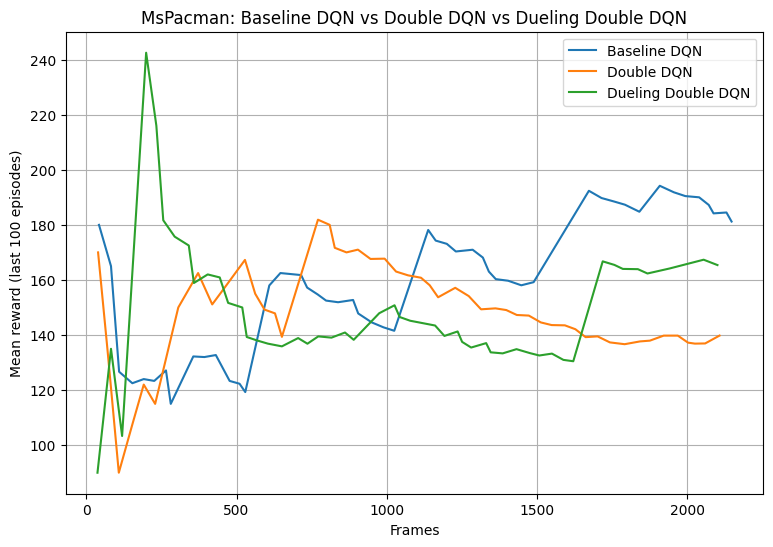

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))

plt.plot(baseline_hist["frames"], baseline_hist["mean100"], label="Baseline DQN")
plt.plot(double_hist["frames"],   double_hist["mean100"],   label="Double DQN")
plt.plot(dueling_hist["frames"],  dueling_hist["mean100"],  label="Dueling Double DQN")

plt.xlabel("Frames")
plt.ylabel("Mean reward (last 100 episodes)")
plt.title("MsPacman: Baseline DQN vs Double DQN vs Dueling Double DQN")
plt.legend()
plt.grid(True)
plt.show()


## 14. Recorder Helper




In [40]:
import imageio.v2 as imageio

def record_clip(env_id, policy_net, eps=1.0, target_seconds=12, save_fps=15,
                slow_factor=2, out_path="video.mp4", seed=0, max_episodes=6):
    """
    save_fps: frames per second in the output video (lower = slower playback)
    slow_factor: duplicate each rendered frame this many times (bigger = slower)
    """
    target_frames = int(target_seconds * save_fps)
    frames = []
    env = make_env(env_id, n_steps=4, render_mode="rgb_array")
    dev = next(policy_net.parameters()).device
    rng = np.random.RandomState(seed)

    episodes = 0
    while len(frames) < target_frames and episodes < max_episodes:
        s, _ = env.reset(seed=int(rng.randint(0, 1_000_000)))
        done = False
        trunc = False
        while not (done or trunc) and len(frames) < target_frames:
            if rng.rand() < eps:
                a = env.action_space.sample()
            else:
                with torch.no_grad():
                    sv = torch.as_tensor(s, device=dev).unsqueeze(0)
                    q = policy_net(sv)
                    a = int(torch.argmax(q, dim=1).item())
            ns, r, done, trunc, _ = env.step(a)
            frame = env.render()
            # duplicate frames to slow apparent motion
            frames.extend([frame] * slow_factor)
            s = ns
        episodes += 1

    if not frames:
        raise RuntimeError("No frames recorded.")
    # trim/pad to exact length
    if len(frames) >= target_frames:
        frames = frames[:target_frames]
    else:
        frames = frames + [frames[-1]] * (target_frames - len(frames))

    imageio.mimsave(out_path, frames, fps=save_fps)
    env.close()
    print(f"Saved {out_path} — {len(frames)/save_fps:.1f}s at {save_fps} fps (slow_factor={slow_factor})")


## 15. Make Videos: Baseline DQN vs Dueling Double DQN

To highlight **behavioral differences**, we record:

- A clip from the **baseline DQN** agent (ε ≈ 0.01)  
- A clip from the **Dueling Double DQN** agent (ε ≈ 0.01)  

Each clip is ~25 seconds long with slowed playback.


In [47]:
import os
os.makedirs("videos", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

baseline_net = baseline_net.to(device)
dueling_net  = dueling_net.to(device)

# Baseline DQN clip
record_clip(
    env_id=DEFAULT_ENV_NAME,
    policy_net=baseline_net,
    eps=0.1,
    target_seconds=30,
    save_fps=15,
    slow_factor=2,
    out_path="videos/baseline_mspacman.mp4",
    seed=0
)

# Dueling Double DQN clip
record_clip(
    env_id=DEFAULT_ENV_NAME,
    policy_net=dueling_net,
    eps=0.1,
    target_seconds=30,
    save_fps=15,
    slow_factor=2,
    out_path="videos/dueling_mspacman.mp4",
    seed=1
)


Creating environment ALE/MsPacman-v5


Saved videos/baseline_mspacman.mp4 — 30.0s at 15 fps (slow_factor=2)
Creating environment ALE/MsPacman-v5


Saved videos/dueling_mspacman.mp4 — 30.0s at 15 fps (slow_factor=2)


## 16. Preview Videos in Colab

Display both videos using `IPython.display.Video` so they can be directly embedded in your report or demo.


In [48]:
from IPython.display import Video, display

display(Video("videos/baseline_mspacman.mp4", embed=True, width=480))



In [49]:
display(Video("videos/dueling_mspacman.mp4",  embed=True, width=480))